# Gaussian Process
---

A [Gaussian Processes](https://en.wikipedia.org/wiki/Gaussian_process) is a collection of random variables such that every finite collection of those random variables has a multivariate normal distribution, which means that every possible linear combination of them is normally distributed. (Gaussian processes can be seen as an infinite-dimensional generalization of multivariate normal distributions). 

<img src='https://dev.heuristiclab.com/trac.fcgi/raw-attachment/blog/gkronber/gaussian_processes/GP%20samples%20I.png'>

The distribution of the GP is the [**joint distribution**](https://en.wikipedia.org/wiki/Joint_distribution) of all those random variables.  
In few words, GPs use the **kernel function** that determines the similarity between point to predict the value for an unseen point. 

[This video](https://www.youtube.com/watch?v=UpsV1y6wMQ8&t=3578s) is a fantastic quick intro to Gaussian Process to predict CO2 levels.  
[This book](http://www.gaussianprocess.org/gpml/chapters/RW.pdf) is the main guide to Gaussian Processes.  

One clear **advantage** of GP is the fact that we obtain an **standard deviation** at every prediction, than can be easily used to perform a confindence interval around the predictions.  

In [17]:
import time
import copy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

np.random.seed(2018)

(475, 22)


<function matplotlib.pyplot.show>

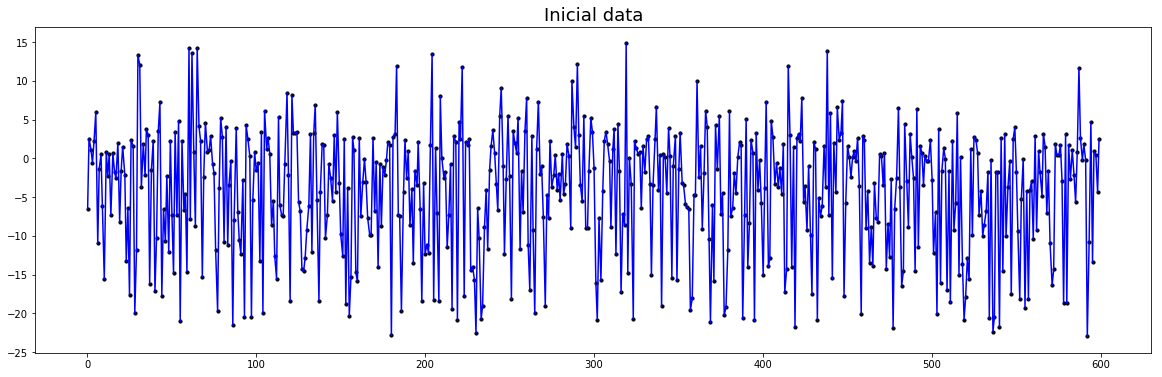

In [18]:
##############################################################################
# IMPORT DATA AND WINDOWS
##############################################################################
path_to_data = './windows_ts.h5'

dataset = pd.read_hdf(path_to_data, 'dataset')
trainset = pd.read_hdf(path_to_data, 'trainset')
testset = pd.read_hdf(path_to_data, 'testset')

train_windows = pd.read_hdf(path_to_data, 'train_windows')
test_windows = pd.read_hdf(path_to_data, 'test_windows')
train_windows_y_inc = pd.read_hdf(path_to_data, 'train_windows_y_inc')
test_windows_y_inc = pd.read_hdf(path_to_data, 'test_windows_y_inc')

# Bring here the window used
w = 5
print(train_windows.shape)

plt.figure(figsize=(20,6))
plt.title('Inicial data', fontsize=18)
plt.plot(dataset['t'], dataset['y'], 'b-')
plt.scatter(dataset['t'], dataset['y'], color='black', s=10)
plt.show

In [19]:
##############################################################################
# CREATION OF THE MODEL
##############################################################################        
from sklearn.gaussian_process import GaussianProcessRegressor as GP
from sklearn.gaussian_process.kernels import ConstantKernel as C
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import ExpSineSquared as ES
from sklearn.gaussian_process.kernels import DotProduct as DP
from sklearn.gaussian_process.kernels import Matern 
from sklearn.gaussian_process.kernels import WhiteKernel as WK

In [20]:
l = 2.
kernels = {'cnt': C(constant_value=0.1),
           'rbf': RBF(length_scale=l),
           'ex2': ES(length_scale=l),
           'dot': DP(sigma_0=0.1),
           'mat': Matern(length_scale=l , nu=1.5),
           'whi': WK(noise_level=0.01)}
           
k = kernels['cnt'] + kernels['ex2'] + kernels['rbf'] 
if 'gp' in locals(): del gp
gp = GP(kernel=k, n_restarts_optimizer=9, normalize_y=True)

We can play with different kernels. I recommend chapter 5 of the book which I provided the link at the top to understand the use of each kernels and what they parameters mean.

In [21]:
##############################################################################
# TRAIN THE NETWORK AND PREDICT - Without previous y
############################################################################## 
# Train
trainX = train_windows.values[:,:-1]
trainY = train_windows.values[:,-1]
testX = test_windows.values[:,:-1]
testY = test_windows.values[:,-1]

t0 = time.time()
gp.fit(train_windows.values[:,:-1], train_windows.values[:,-1])
tF = time.time()

# Predict
gp_y_fit = gp.predict(train_windows.values[:,:-1], return_std=False)
gp_y_pred, gp_y_std = gp.predict(test_windows.iloc[:,:-1], return_std=True)

gp_y_up = (gp_y_pred + 1.96 * gp_y_std).reshape(-1,)
gp_y_lw = (gp_y_pred - 1.96 * gp_y_std).reshape(-1,)
gp_y_pred = gp_y_pred.reshape(-1,1)


# Calculating Errors
gp_residuals = gp_y_pred - testset.iloc[5:,-1].values.reshape(-1,1)
gp_rmse = np.sqrt(np.sum(np.power(gp_residuals,2)) / len(gp_residuals))
print('RMSE = %f' % gp_rmse)
print('Time to train %.2f' % (tF - t0))


/Users/pablorr10/miniconda3/envs/AI/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.92521531e+05,  1.57105450e+08,  4.29897696e+23, -0.00000000e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 70, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


RMSE = 2.320005
Time to train 4.17


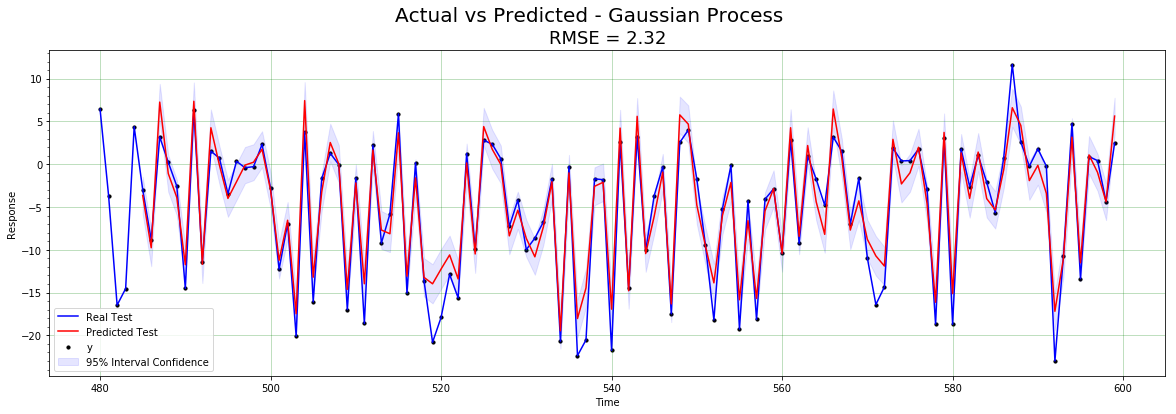

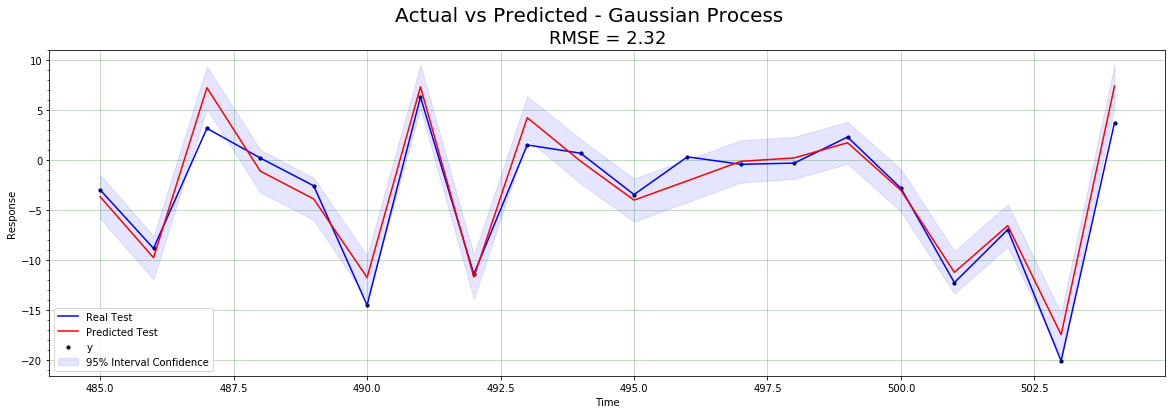

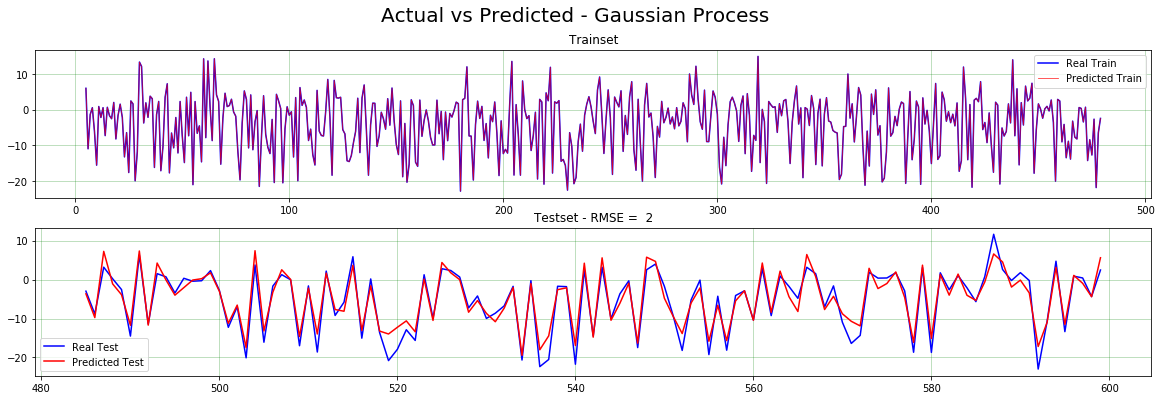

In [32]:
# Plot predictions
f, ax = plt.subplots(1, figsize=(20,6))
plt.suptitle('Actual vs Predicted - Gaussian Process' , fontsize=20)
plt.title('RMSE = %.2f' % gp_rmse, fontsize = 18)
plt.grid(color='green', linewidth=0.5, alpha=0.5)

plt.scatter(testset.index, testset.y, color='black', s=10)
plt.plot(testset.index, testset.y, color='b', label='Real Test')
plt.plot(testset.index[w:], gp_y_pred, color='r', label='Predicted Test')
plt.fill_between(testset.index[w:], gp_y_lw, gp_y_up, 
                 color='blue', alpha=0.1, label='95% Interval Confidence')

ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.xlabel('Time')
plt.ylabel('Response')
plt.legend()
plt.show()

# Plot zoomed predictions
f, ax = plt.subplots(1, figsize=(20,6))
plt.suptitle('Actual vs Predicted - Gaussian Process' , fontsize=20)
plt.title('RMSE = %.2f' % gp_rmse, fontsize = 18)
plt.grid(color='green', linewidth=0.5, alpha=0.5)

plt.scatter(testset.index[w:20+w], testset.y[w:20+w], color='black', s=10)
plt.plot(testset.index[w:20+w], testset.y[w:20+w], color='b', label='Real Test')
plt.plot(testset.index[w:20+w], gp_y_pred[:20], color='r', label='Predicted Test')
plt.fill_between(testset.index[w:20+w], gp_y_lw[:20], gp_y_up[:20], 
                 color='blue', alpha=0.1, label='95% Interval Confidence')

ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.xlabel('Time')
plt.ylabel('Response')
plt.legend()
plt.show()

# Complete Plot
f, (ax1, ax2) = plt.subplots(2,1, figsize=(20,6))
plt.suptitle('Actual vs Predicted - Gaussian Process' , fontsize=20)
ax1.grid(color='green', linewidth=0.5, alpha=0.5)
ax2.grid(color='green', linewidth=0.5, alpha=0.5)

ax1.plot(trainset.index[w:], train_windows['y'], color='b', label='Real Train')
ax1.plot(trainset.index[w:], gp_y_fit, color='r',
         linewidth=0.8, alpha=0.8, label='Predicted Train')
ax1.legend()
ax1.set_title('Trainset')

ax2.plot(testset.index[w:], test_windows['y'], color='b', label='Real Test')
ax2.plot(testset.index[w:], gp_y_pred, color='r', label='Predicted Test')
ax2.set_title('Testset - RMSE = %2.f' % gp_rmse)
ax2.legend()

plt.show()     

The fit on the train data is a **perfect fit!**. The results on the validation set is also very surprising, following the trend almost with perfect accuracy.

In [33]:
##############################################################################
# TRAIN THE NETWORK AND PREDICT - With previous y
############################################################################## 
# Train
trainX = train_windows_y_inc.values[:,:-1]
trainY = train_windows_y_inc.values[:,-1]
testX = test_windows_y_inc.values[:,:-1]
testY = test_windows_y_inc.values[:,-1]

if 'gp_inc' in locals(): del gp_inc
gp_inc = GP(kernel=k, n_restarts_optimizer=9)
t0 = time.time()
gp_inc.fit(trainX,trainY)
tF = time.time()

# Predict
gp_y_fit_inc = gp_inc.predict(train_windows_y_inc.values[:,:-1], return_std=False)
gp_y_pred_inc, gp_y_std_inc = gp_inc.predict(test_windows_y_inc.iloc[:,:-1], return_std=True)

gp_y_up_inc = (gp_y_pred_inc + 1.96 * gp_y_std_inc).reshape(-1,)
gp_y_lw_inc = (gp_y_pred_inc - 1.96 * gp_y_std_inc).reshape(-1,)
gp_y_pred_inc = gp_y_pred_inc.reshape(-1,1)


# Calculating Errors
gp_residuals_inc = gp_y_pred_inc - testset.iloc[5:,-1].values.reshape(-1,1)
gp_rmse_inc = np.sqrt(np.sum(np.power(gp_residuals_inc,2)) / len(gp_residuals_inc))
print('RMSE = %f' % gp_rmse_inc)
print('Time to train %.2f' % (tF - t0))

/Users/pablorr10/miniconda3/envs/AI/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.78055332e+00,  6.50198605e+00, -5.74734022e+12, -5.94456231e-09]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 68, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


RMSE = 5.375457
Time to train 6.68


/Users/pablorr10/miniconda3/envs/AI/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-8.74645602e+01,  6.77663004e+00, -2.01312028e+11, -3.94950004e+02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  " state: %s" % convergence_dict)


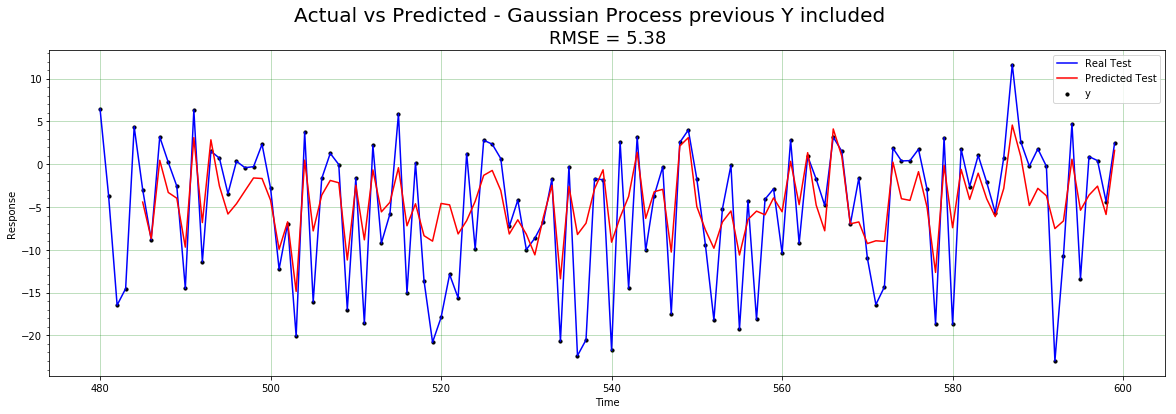

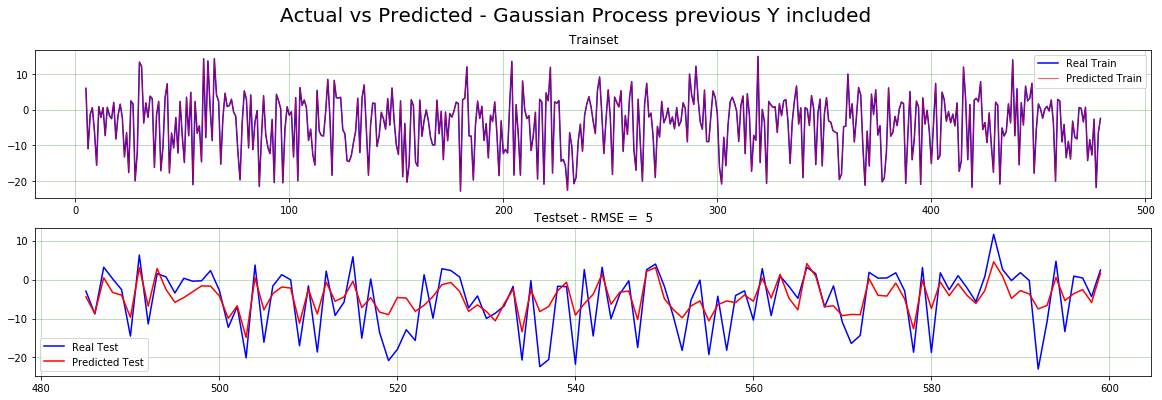

In [34]:
# Plot predictions
f, ax = plt.subplots(1, figsize=(20,6))
plt.suptitle('Actual vs Predicted - Gaussian Process previous Y included' , fontsize=20)
plt.title('RMSE = %.2f' % gp_rmse_inc, fontsize = 18)
plt.grid(color='green', linewidth=0.5, alpha=0.5)

plt.scatter(testset.index, testset.y, color='black', s=10)
plt.plot(testset.index, testset.y, color='b', label='Real Test')
plt.plot(testset.index[w:], gp_y_pred_inc, color='r', label='Predicted Test')

ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.xlabel('Time')
plt.ylabel('Response')
plt.legend()
plt.show()


# Complete Plot
f, (ax1, ax2) = plt.subplots(2,1, figsize=(20,6))
plt.suptitle('Actual vs Predicted - Gaussian Process previous Y included' , fontsize=20)
ax1.grid(color='green', linewidth=0.5, alpha=0.5)
ax2.grid(color='green', linewidth=0.5, alpha=0.5)

ax1.plot(trainset.index[w:], train_windows['y'], color='b', label='Real Train')
ax1.plot(trainset.index[w:], gp_y_fit_inc, color='r',
         linewidth=0.8, alpha=0.8, label='Predicted Train')
ax1.legend()
ax1.set_title('Trainset')

ax2.plot(testset.index[w:], test_windows['y'], color='b', label='Real Test')
ax2.plot(testset.index[w:], gp_y_pred_inc, color='r', label='Predicted Test')
ax2.set_title('Testset - RMSE = %2.f' % gp_rmse_inc)
ax2.legend()

plt.show()

The fit in the trainning data is again perfect, but the performance in the validation is far worse that if we don't show the model previous values of the response.

**Conclusion**

We have seen how Gaussian Processes are another wonderfull approach with a high predicting power. This model also get worse resulst where introducing previous values of the response as predictors.  

The main point, is that we can play with an almost **infinite combination of tuned kernels** to look for the combination of random variables which their joint distribution better fits our model. I encourage you to try your own kernel and improve those results!  

